In [1]:
#This file contains scripts that can be used to test the trained model

In [2]:
import boto3
import botocore
import sagemaker
import sys
import datetime
from tzlocal import get_localzone as tzlocal
import time
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import io
import json


In [3]:
def plot_result(ax1, indata, cutoffs, is_cutoff, y_label, color):
        
    start, end = 0, len(indata)
    indata_subset = indata[start:end]
    plt.style.use('default')

    ax1.plot(indata, color=color)
 
    if is_cutoff == True:
        ax1.plot(cutoffs, color = 'red')        

    ax1.grid(which='major', axis='both')
    ax1.set_ylabel(y_label, color='C0') 

In [4]:
def plot_results(indata, threshold, in_scores, is_stepbystep):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plt.style.use('default')

    start, end = 0, len(indata)
    indata_subset = indata[start:end]

    ax1.plot(indata_subset.iloc[:, 1], color='C0', alpha=0.8)
    ax2.plot(indata_subset['score'], color='C1')
    if is_stepbystep == False:
        ax2.plot(numpy.full(len(indata_subset), threshold), color = 'C2')
    else:
        ax2.plot(indata_subset['cutoff'], color = 'C2')

    ax1.grid(which='major', axis='both')

    ax1.set_ylabel('Sum value', color='C0')
    ax2.set_ylabel('Anomaly Score', color='C1')

    ax1.tick_params('y', colors='C0')
    ax2.tick_params('y', colors='C1')    

    ax1.set_ylim(0, numpy.max(indata.iloc[:, 1]))
    if is_stepbystep == False:
        ax2.set_ylim(min(in_scores), 1.4*max(in_scores))
    else:
        ax2.set_ylim(indata['score'].min(), 1.6*indata['score'].max())
    fig.set_figwidth(12) 
   

In [5]:
#Define bucket name 
bucket = 'kintestingdata'
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()
# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://kintestingdata/sagemaker/rcf-benchmarks


In [6]:
#A path to test data in s3

key = 'rcf/playdata/test/medium_one_min.csv'
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=key)
test_data = pd.read_csv(io.BytesIO(obj['Body'].read()),  delimiter=',', header=None)
test_data = test_data.dropna()
test_data.head()

,0,1
0,2018-12-21_15-16,138
1,2018-12-21_15-19,72
2,2018-12-21_15-22,62
3,2018-12-21_15-23,56
4,2018-12-21_15-24,257


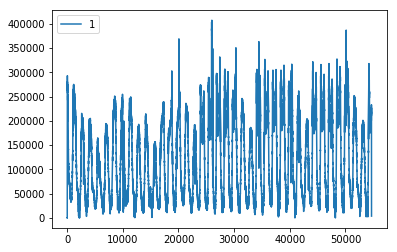

In [7]:
test_data.plot()

In [8]:
#Day by day testing
#The data is fed into the model day by day, and an anomaly threshold is computed per each day
#For this, we add an additional 'Day' column

#strdates = test_data[0].str.split(" ", n = 1, expand = True)[0]
strdates = test_data[0].str[0:10]
test_data['strdate'] = pd.Series(strdates, index=test_data.index)
test_data['cutoff'] = pd.Series(numpy.zeros(len(strdates)), index=test_data.index)

In [9]:
#The script invokes the model for each day-length data and prints to the log anomaly points that are beyound the threshold
#The threshold is defined as a three standard deviations from the mean

unique_dates = test_data.groupby("strdate").nunique().index
newdataframe = pd.DataFrame
a = 0

for i in unique_dates:
    day_subset = test_data[test_data['strdate'] == i]
    
    num_array = numpy.array(day_subset.values[:, 1]).reshape(-1,1)
    runtime= boto3.client('runtime.sagemaker')
    response = runtime.invoke_endpoint(EndpointName='randomcutforest-2019-02-23-15-49-47-553', ContentType='text/csv',
                                       Body=pd.DataFrame(num_array).to_csv(index=False, header=False))
    
    results = json.loads(response['Body'].read().decode("utf-8"))        
    scores = [datum['score'] for datum in results['scores']]

    test_data.loc[test_data["strdate"] == i, 'score'] = scores
       
    scores_array = numpy.array(scores)
    score_mean = scores_array.mean()
    score_std = scores_array.std()
    score_cutoff = score_mean + 3*score_std
    test_data.loc[test_data["strdate"] == i, 'cutoff'] = score_cutoff
    
    anomalies = scores_array[scores_array > score_cutoff]
    if (len(anomalies) > 0):
        anom_indices = numpy.argwhere(scores_array > score_cutoff)
        print(test_data.loc[(test_data["strdate"] == i) & (test_data["score"] > score_cutoff)])
     
print('Finished!')   

                   0     1     strdate    cutoff     score
0   2018-12-21_15-16   138  2018-12-21  5.015003  5.072817
1   2018-12-21_15-19    72  2018-12-21  5.015003  5.074178
2   2018-12-21_15-22    62  2018-12-21  5.015003  5.074384
3   2018-12-21_15-23    56  2018-12-21  5.015003  5.074507
4   2018-12-21_15-24   257  2018-12-21  5.015003  5.070351
5   2018-12-21_15-25   114  2018-12-21  5.015003  5.073313
7   2018-12-21_15-34   226  2018-12-21  5.015003  5.070995
8   2018-12-21_15-41  1747  2018-12-21  5.015003  5.038744
9   2018-12-21_15-43  1729  2018-12-21  5.015003  5.039140
11  2018-12-21_15-48    68  2018-12-21  5.015003  5.074260
12  2018-12-21_15-49   196  2018-12-21  5.015003  5.071617
13  2018-12-21_15-50    52  2018-12-21  5.015003  5.074589
14  2018-12-21_15-53    24  2018-12-21  5.015003  5.075164
15  2018-12-21_15-55  2479  2018-12-21  5.015003  5.022432
16  2018-12-21_15-56   392  2018-12-21  5.015003  5.067532
17  2018-12-21_15-57   544  2018-12-21  5.015003  5.0643

                      0       1     strdate    cutoff     score
27415  2019-01-09_16-36  331864  2019-01-09  5.004325  5.377883
                      0       1     strdate    cutoff     score
28330  2019-01-10_07-51  306903  2019-01-10  5.025386  5.044356
                      0       1     strdate    cutoff     score
30317  2019-01-11_16-58  342756  2019-01-11  5.003951  5.466927
30318  2019-01-11_16-59  350747  2019-01-11  5.003951  5.520535
30319  2019-01-11_17-00  333612  2019-01-11  5.003951  5.393757
30320  2019-01-11_17-01  344119  2019-01-11  5.003951  5.476659
30321  2019-01-11_17-02  345375  2019-01-11  5.003951  5.485398
30325  2019-01-11_17-06  315641  2019-01-11  5.003951  5.186199
30327  2019-01-11_17-08  307626  2019-01-11  5.003951  5.056343
30328  2019-01-11_17-09  314759  2019-01-11  5.003951  5.169365
30331  2019-01-11_17-12  331283  2019-01-11  5.003951  5.372445
30334  2019-01-11_17-15  321306  2019-01-11  5.003951  5.266734
                      0      1     strda

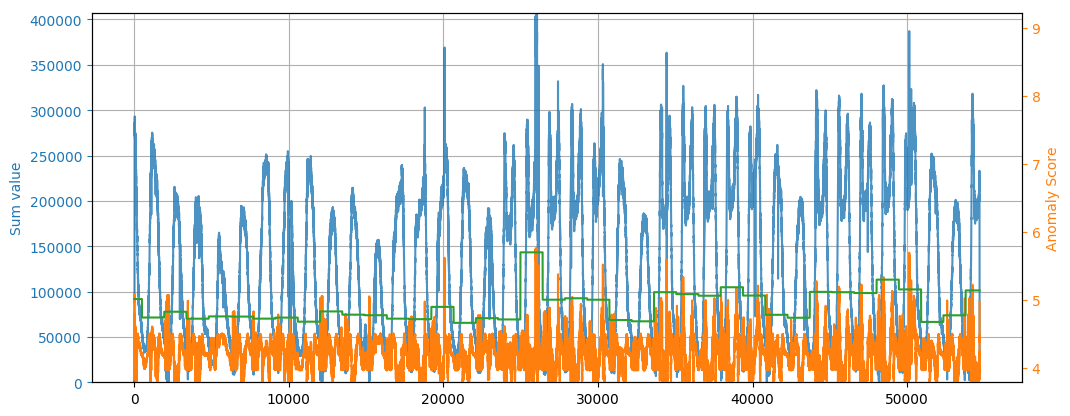

In [12]:
#Plotting results and saving to a csv file
#A green line corresponds to threshold values, an orange line depicts anomaly scores, and blue one represents the data

plot_results(test_data, '', '', True)
#test_data.to_csv('rcf_test_data_results.csv', sep='\t')

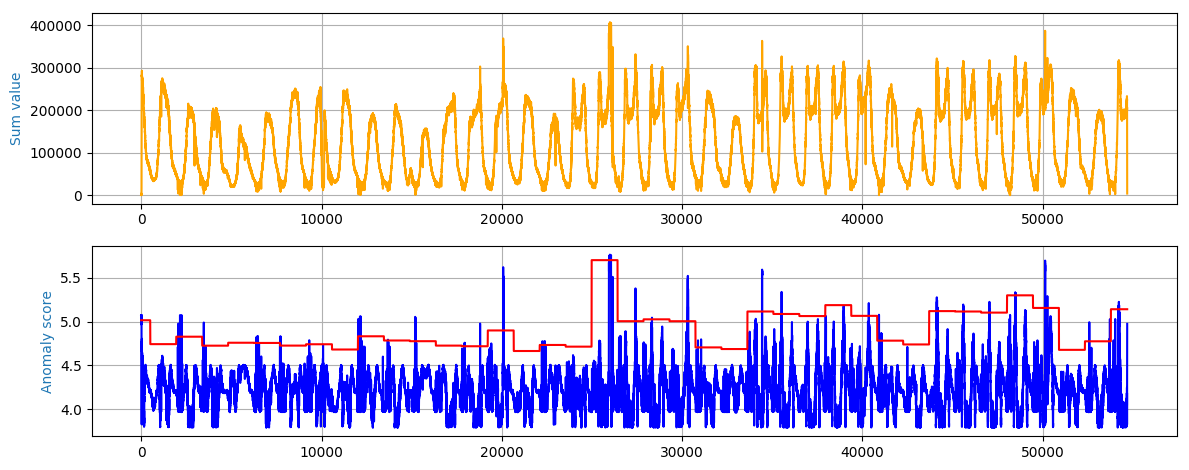

In [13]:
#Plotting results in separate subplots

fig, (px1, px2) = plt.subplots(nrows=2, ncols=1)

fig.set_figwidth(12)
plot_result(px1, test_data.iloc[:, 1], '',  False, 'Sum value', 'orange')
plot_result(px2, test_data['score'], test_data['cutoff'],  True, 'Anomaly score', 'blue')
plt.tight_layout()